In [12]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier


#from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight

import numpy as np
import pandas as pd



data = pd.read_csv('Train_clean.csv')
data  = data.drop("not_alone", axis=1)
#test  = test.drop("not_alone", axis=1)

data  = data.drop("Parch", axis=1)
#test  = test.drop("Parch", axis=1)

In [13]:
X = data.drop(columns=['Survived', "Unnamed: 0"], axis=1)
y = data.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0)


In [14]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

### Random Forest Classifier

In [15]:
random_forest = RandomForestClassifier(criterion = "gini", 
                                       min_samples_leaf = 1, 
                                       min_samples_split = 10,   
                                       n_estimators=100, 
                                       max_features='auto', 
                                       oob_score=True, 
                                       random_state=1, 
                                       n_jobs=-1)

random_forest.fit(X_train_norm, y_train)
Y_prediction = random_forest.predict(X_test_norm)

random_forest.score(X_train_norm, y_train)

acc_random_forest = round(random_forest.score(X_train_norm, y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")

88.48 %


In [ ]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
Fare,0.268
Title,0.203
Sex,0.148
Age,0.110
relatives,0.067
Pclass,0.063
Deck,0.059
SibSp,0.050
Embarked,0.033


/shared-libs/python3.7/py/lib/python3.7/site-packages/joblib/externals/loky/backend/resource_tracker.py:120: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some folders/sempahores might leak.
  warnings.warn('resource_tracker: process died unexpectedly, '


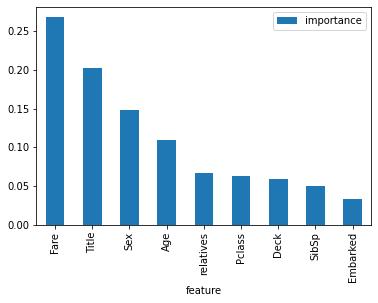

In [ ]:
importances.plot.bar();

In [ ]:
param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10, 25, 50, 70], "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], "n_estimators": [100, 400, 700, 1000, 1500]}
from sklearn.model_selection import GridSearchCV, cross_val_score
rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)
clf.fit(X_train_norm, y_train)
clf.bestparams

In [16]:
from sklearn.metrics import roc_auc_score
y_scores = random_forest.predict_proba(X_train_norm)
y_scores = y_scores[:,1]

r_a_score = roc_auc_score(y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.940457416539421


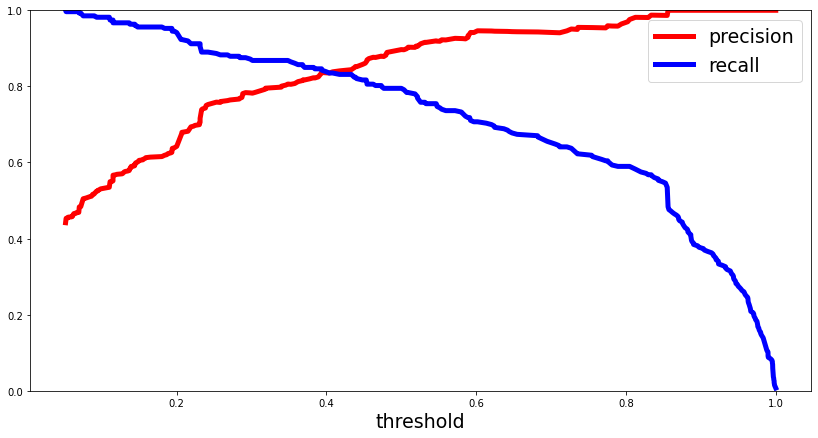

In [17]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

### SVC

In [24]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 1000],  
              'gamma': ['scale', 1, 0.1, 0.0001], 'kernel': ['poly', 'rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, verbose=1) 
  

In [25]:
grid.fit(X_train_norm, y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

Fitting 5 folds for each of 32 candidates, totalling 160 fits
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
SVC(C=1)


In [26]:
svc_pred = grid.predict(X_test_norm)

In [32]:
accuracy_score(y_test, svc_pred)

0.8268156424581006

In [ ]:
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [ ]:
models1 = {
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
}

params1 = {
    'ExtraTreesClassifier': {'n_estimators': [16, 32] },
    'RandomForestClassifier': {'n_estimators': [16, 32] },
    'AdaBoostClassifier':  {'n_estimators': [16, 32] },
    'GradientBoostingClassifier': {'n_estimators': [16, 32], 'learning_rate': [0.8, 1.0] }
}

In [ ]:
models2 = {
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'SVC': SVC(),
}

params2 = {
    'ExtraTreesClassifier': {'n_estimators': [16, 32] },
    'RandomForestClassifier': {'n_estimators': [16, 32] },
    'AdaBoostClassifier':  {'n_estimators': [16, 32] },
    'GradientBoostingClassifier': {'n_estimators': [16, 32], 'learning_rate': [0.8, 1.0] },
    'SVC': [
        {'kernel': ['linear'], 'C': [1, 10, 100]},
        {'kernel': ['rbf', 'poly', 'sigmoid', 'linear'], 'C':[0.1, 1, 10, 100], 'gamma': [1,0.1,0.01,0.001]},
    ]
}

In [ ]:
pred = clf.predict(X_test_norm)

clf.score(X_test_norm, y_test)

In [ ]:
10.0 ** -np.arange(1, 5)

In [ ]:
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(X_train_norm, y_train, scoring='f1', n_jobs=2)

Running GridSearchCV for ExtraTreesClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits
/shared-libs/python3.7/py/lib/python3.7/site-packages/joblib/externals/loky/backend/resource_tracker.py:120: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some folders/sempahores might leak.
  warnings.warn('resource_tracker: process died unexpectedly, '
exception calling callback for <Future at 0x7fc790ab3590 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/joblib/parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/joblib/parallel.py", line 792, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/shared-libs/

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {EXIT(1)}

In [ ]:
display(helper1.score_summary(sort_by='max_score').head(20))

In [ ]:
'LogReg': LogisticRegression()
'LinReg': LinearRegression()
'KNeighborsClassifier': KNeighborsClassifier()

### MLP

In [ ]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X_train_norm, y_train)

In [ ]:
mlp_gs = MLPClassifier(max_iter=50)
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd'],
    'alpha': list(10.0 ** -np.arange(1, 7)), 'random_state': [0],
    'momentum': [0.99, 0.5, 0.1, 0.01, 0.001], 'early_stopping': [True]}
from sklearn.model_selection import GridSearchCV
mlp_clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
mlp_clf.fit(X_train_norm, y_train)

exception calling callback for <Future at 0x7f219036ce90 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/joblib/parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/joblib/parallel.py", line 792, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/joblib/_parallel_backends.py", line 531, in

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {EXIT(1)}

In [ ]:
mlp_clf.best_params_

{'activation': 'tanh',
 'alpha': 0.1,
 'early_stopping': True,
 'hidden_layer_sizes': (10, 30, 10),
 'momentum': 0.99,
 'random_state': 0,
 'solver': 'sgd'}

In [ ]:
pred = mlp_clf.predict(X_test_norm)

mlp_clf.score(X_test_norm, y_test)

0.7932960893854749

In [ ]:
tuned_parameters = [{'alpha': list(10.0 ** -np.arange(1, 7)), 'activation': ('identity', 'logistic', 'tanh', 'relu'),
                     'random_state': [0], 'verbose' : [3]}]

scores = ['precision', 'recall']


for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        MLPClassifier(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train_norm, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test_norm)
    print(classification_report(y_true, y_pred))
    print()


Iteration 27, loss = 0.41420798
Iteration 28, loss = 0.41352678
Iteration 29, loss = 0.41290442
Iteration 30, loss = 0.41236020
Iteration 31, loss = 0.41191421
Iteration 32, loss = 0.41169502
Iteration 33, loss = 0.41133468
Iteration 34, loss = 0.41099500
Iteration 35, loss = 0.41078443
Iteration 36, loss = 0.41059346
Iteration 37, loss = 0.41034743
Iteration 38, loss = 0.41016852
Iteration 39, loss = 0.40999217
Iteration 40, loss = 0.40987374
Iteration 41, loss = 0.40972533
Iteration 42, loss = 0.40963890
Iteration 43, loss = 0.40953258
Iteration 44, loss = 0.40936160
Iteration 45, loss = 0.40920815
Iteration 46, loss = 0.40912359
Iteration 47, loss = 0.40891048
Iteration 48, loss = 0.40877274
Iteration 49, loss = 0.40863469
Iteration 50, loss = 0.40850314
Iteration 51, loss = 0.40844405
Iteration 52, loss = 0.40831000
Iteration 53, loss = 0.40809418
Iteration 54, loss = 0.40805703
Iteration 55, loss = 0.40789685
Iteration 56, loss = 0.40777843
Iteration 57, loss = 0.40773617
Iteratio

In [ ]:
tuned_parameters = [{'solver': ['lbfgs'], 'alpha': list(10.0 ** -np.arange(1, 7)), 'activation': ['tanh'],
                     'random_state': [0]}]

clf = GridSearchCV(MLPClassifier(), tuned_parameters)
clf.fit(X_train_norm, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)


print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test_norm)
print(classification_report(y_true, y_pred))
print()


/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (

KeyboardInterrupt: 